In [1]:
import glob
import os
import re
import itertools
import multiprocessing
import dataclasses
from pathlib import Path

import lxml.etree as etree
import tqdm

import whoosh.fields
from whoosh.fields import ID, NGRAM, NUMERIC
import whoosh.index
import whoosh.qparser
import jellyfish
import pandas as pd

import abctk.obj.comparative as aoc

In [2]:
class BCCWJSent(whoosh.fields.SchemaClass):
    sampleID = ID(stored = True)
    sent_start_pos = NUMERIC(stored = True)
    text = NGRAM(stored = True)

StartPos_UNKNOWN = 1000000000

@dataclasses.dataclass
class Match:
    ID_current: str
    found_bccwj_file: str | None
    found_bccwj_start: int | None
    text_original: str
    text_found: str | None
    match_score: float

In [3]:
BCCWJ_GLOBS = (
    "/home/owner/BCCWJ/CORE_NT/core_M-XML/*.xml",
    "/home/owner/BCCWJ/LB/**/*.xml",
)
INDEX_PATH = Path("../BCCWJ_INDICES")
ANNOT_FILE = Path("/home/owner/ABCT/comp-proto/comparative-annotation_linearilized_current.txt")
OUTPUT_PATH: Path = Path("result.csv")

In [ ]:
if not INDEX_PATH.exists():
    os.mkdir(INDEX_PATH)

file_list = tuple(
    itertools.chain.from_iterable(
        glob.glob(p) for p in BCCWJ_GLOBS
    )
)

index = whoosh.index.create_in(INDEX_PATH.name, BCCWJSent)

with index.writer(
    procs = multiprocessing.cpu_count(), 
    multisegment = True
) as writer:
    for fp in tqdm.tqdm(
        file_list,
        desc = "Incorporating documents",
        total = len(file_list), 
        unit = "file(s)"
    ):
        doc = etree.parse(fp)
        for mergedSample in doc.xpath("//mergedSample"):
            sampleID: str = mergedSample.attrib.get("sampleID", "<NO_SAMPLE_ID>")

            for sent in mergedSample.xpath(".//sentence"):
                suws = tuple(sent.xpath(".//SUW"))
                first_pos = StartPos_UNKNOWN
                if suws and (pos_str := suws[0].get("start")):
                    first_pos = int(pos_str)

                writer.add_document(
                    sampleID = sampleID,
                    sent_start_pos = first_pos,
                    text = "".join(
                        (s.attrib.get("originalText", s.text or ""))
                        for s in suws
                    )
                )

In [5]:
WINDOW = 10

with open(ANNOT_FILE) as af:
    annots = tuple(
        aoc.read_bracket_annotation_file(af)
    )
index = whoosh.index.open_dir(INDEX_PATH)
qparser = whoosh.qparser.QueryParser("text", index.schema)

matching: dict[str, Match] = {}

with index.searcher() as searcher:
    for record in tqdm.tqdm(
        annots,
        desc = "searching the BCCWJ corpus",
        total = len(annots),
        unit = "sent(s)",
    ):
        ID = record["ID"]
        text = "".join(record["tokens"])
        results = searcher.search(
            qparser.parse(
                " OR ".join(
                    text[(i * WINDOW):((i + 1) * WINDOW)]
                    for i in range(len(text) // WINDOW + 1)
                )
            )
        )

        match len(results):
            case 0:
                record["ID_previous"] = ID
                record["ID"] = ""

                match = Match(
                    ID_current = ID,
                    found_bccwj_file = None,
                    found_bccwj_start = None,
                    text_original = text,
                    text_found = None,
                    match_score = 0,
                )
            case 1:
                res, = results
                match = Match(
                    ID_current = ID,
                    found_bccwj_file = res["sampleID"],
                    found_bccwj_start = res["sent_start_pos"],
                    text_original = text,
                    text_found = res["text"],
                    match_score = res.score,
                )

                record["ID_previous"] = ID
                record["ID"] = match.generate_new_ID()
            case _:
                res1, res2, *res_rem = results
                res_max = max(
                    res1, res2, *res_rem,
                    key = lambda i: i.score,
                )
                
                match = Match(
                    ID_current = ID,
                    bccwj_pos = (res_max["sampleID"], res_max["sent_start_pos"]),
                    text_original = text,
                    text_found = res_max["text"],
                    match_score = res_max.score,
                )

                record["ID_previous"] = ID
                record["ID"] = match.generate_new_ID()

        matching[ID] = match
    # === END FOR record ===
# === END WITH searcher ===


searching the BCCWJ corpus: 100%|██████████| 3460/3460 [08:39<00:00,  6.67sent(s)/s]


In [6]:
df_matching = pd.DataFrame(matching.values())
df_matching["pred_bccwj_file"] = df_matching[]

In [9]:
def calc_distance(row):
    if row["text_found"]:
        return jellyfish.levenshtein_distance(
            row["text_original"],
            row["text_found"],
        )
    else:
        return float("nan")
    
df_matching["levenshtein"] = df_matching.apply(
    axis = "columns",
    func = calc_distance,
)

<AxesSubplot: >

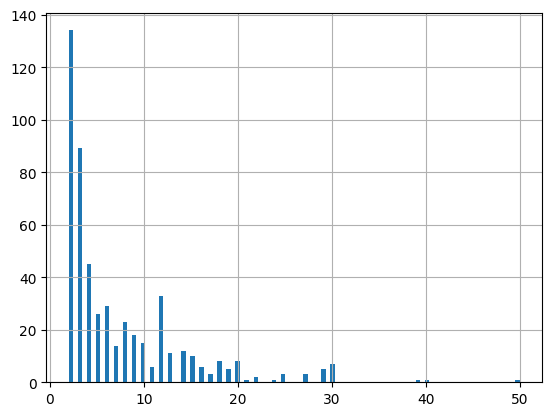

In [16]:
df_matching[df_matching["levenshtein"] > 1]["levenshtein"].hist(bins = 100)

In [24]:
df_matching.to_csv("res.csv", na_rep="NaN")